In [2]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

from xgboost import XGBClassifier, XGBRegressor

import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
DATA_PATH = "Data/"
for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

2024_gt.csv
2024_test.csv
2024_test_R2.csv
2024_test_r3.csv
2024_test_r4.csv
2024_test_r5.csv
2024_test_r6.csv
2024_tourney_seeds.csv
538ratingsMen.csv
538ratingsWomen.csv
Cities.csv
Conferences.csv
EloRating_mens_10.csv
EloRating_womens_10.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thruSeason2024_day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
advanced_metrics.csv
features_mens.csv
fe

In [4]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")

In [4]:
# Proprietary 538 rankings, leaving out for now, can't find corresponding 2024 data
# rankings_538 = pd.read_csv(DATA_PATH + "538ratingsMen.csv")

In [5]:
# ELO ratings
rankings_elo = pd.read_csv(DATA_PATH + "EloRating_mens_10.csv")

# drop First D1 season, last D1 season, and num
rankings_elo = rankings_elo.drop(
    columns=["FirstD1Season", "LastD1Season", "num"]
)

# filter results from 2016 onward
rankings_elo = rankings_elo[rankings_elo["Season"] >= 2016]
rankings_elo

,TeamID,TeamName,Rating,Season
2268,1101,Abilene Chr,42.228205,2016
2269,1102,Air Force,49.529149,2016
2270,1103,Akron,54.285879,2016
2271,1104,Alabama,57.538976,2016
2272,1105,Alabama A&M,38.612385,2016
...,...,...,...,...
5665,1474,Queens NC,46.267687,2024
5666,1475,Southern Indiana,40.700401,2024
5667,1476,Stonehill,39.207474,2024
5668,1477,TX A&M Commerce,41.949530,2024


In [6]:
# Ordinal Rankings
rankings_ordinals = pd.read_csv(DATA_PATH + "MMasseyOrdinals_thruSeason2024_day128.csv")
rankings_ordinals.drop(columns=["SystemName"], inplace=True)
rankings_ordinals = rankings_ordinals[rankings_ordinals["Season"] >= 2016]
# for each season and team id, get the latest ranking
rankings_ordinals = rankings_ordinals.groupby(["Season", "TeamID"]).last().reset_index()
rankings_ordinals.drop(columns=["RankingDayNum"], inplace=True)
rankings_ordinals

,Season,TeamID,OrdinalRank
0,2016,1101,312
1,2016,1102,198
2,2016,1103,60
3,2016,1104,77
4,2016,1105,309
...,...,...,...
3194,2024,1474,266
3195,2024,1475,330
3196,2024,1476,358
3197,2024,1477,318


In [7]:
# merge rankings together on season and teamid
rankings = pd.merge(
    rankings_elo, rankings_ordinals, on=["Season", "TeamID"], how="left"
)

In [8]:
rankings

,TeamID,TeamName,Rating,Season,OrdinalRank
0,1101,Abilene Chr,42.228205,2016,312.0
1,1102,Air Force,49.529149,2016,198.0
2,1103,Akron,54.285879,2016,60.0
3,1104,Alabama,57.538976,2016,77.0
4,1105,Alabama A&M,38.612385,2016,309.0
...,...,...,...,...,...
3397,1474,Queens NC,46.267687,2024,266.0
3398,1475,Southern Indiana,40.700401,2024,330.0
3399,1476,Stonehill,39.207474,2024,358.0
3400,1477,TX A&M Commerce,41.949530,2024,318.0


In [9]:
# seperate rankings for 2024 season
rankings_2024 = rankings[rankings["Season"] == 2024]
rankings = rankings[rankings["Season"] < 2024]

In [10]:
rankings.dropna(inplace=True)

In [11]:
rankings

,TeamID,TeamName,Rating,Season,OrdinalRank
0,1101,Abilene Chr,42.228205,2016,312.0
1,1102,Air Force,49.529149,2016,198.0
2,1103,Akron,54.285879,2016,60.0
3,1104,Alabama,57.538976,2016,77.0
4,1105,Alabama A&M,38.612385,2016,309.0
...,...,...,...,...,...
3018,1473,Lindenwood,43.415253,2023,333.0
3019,1474,Queens NC,47.247387,2023,167.0
3020,1475,Southern Indiana,45.484878,2023,258.0
3021,1476,Stonehill,44.953416,2023,304.0


In [12]:
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
tourney_results.drop(["WLoc", "NumOT"], axis=1, inplace=True)
tourney_results = tourney_results[tourney_results["Season"] >= 2016]
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
1983,2016,134,1195,96,1192,65
1984,2016,134,1455,70,1435,50
1985,2016,135,1221,59,1380,55
1986,2016,135,1276,67,1409,62
1987,2016,136,1114,85,1345,83


In [13]:
tourney_results.drop(["DayNum", "WScore", "LScore"], axis=1, inplace=True)
print(tourney_results.shape)

(468, 3)


In [14]:
df_test = tourney_results
df_test["Pred"] = 0.5
# increment ID for df_test column
df_test["ID"] = df_test.index
df_test

,Season,WTeamID,LTeamID,Pred,ID
1983,2016,1195,1192,0.5,1983
1984,2016,1455,1435,0.5,1984
1985,2016,1221,1380,0.5,1985
1986,2016,1276,1409,0.5,1986
1987,2016,1114,1345,0.5,1987
...,...,...,...,...,...
2446,2023,1274,1400,0.5,2446
2447,2023,1361,1166,0.5,2447
2448,2023,1163,1274,0.5,2448
2449,2023,1361,1194,0.5,2449


In [15]:
# merge features for winning team, returns NaN for every entry, not working correctly
df_test = df_test.merge(
    rankings,
    left_on=["Season", "WTeamID"],
    right_on=["Season", "TeamID"],
    how="left",
)
# rename columns to W prefix
df_test.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)

# merge features for losing team, returns NaN for every entry, not working correctly
df_test = df_test.merge(
    rankings,
    left_on=["Season", "LTeamID"],
    right_on=["Season", "TeamID"],
    how="left",
)
# rename columns to L prefix
df_test.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True,
)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)
df_test

,Season,WTeamID,LTeamID,Pred,ID,TeamNameA,RatingA,OrdinalRankA,TeamNameB,RatingB,OrdinalRankB
0,2016,1195,1192,0.5,1983,FL Gulf Coast,49.033554,206.0,F Dickinson,46.145615,226.0
1,2016,1455,1435,0.5,1984,Wichita St,60.412725,48.0,Vanderbilt,58.381195,66.0
2,2016,1221,1380,0.5,1985,Holy Cross,46.160540,251.0,Southern Univ,44.983788,196.0
3,2016,1276,1409,0.5,1986,Michigan,60.024843,45.0,Tulsa,57.631457,74.0
4,2016,1114,1345,0.5,1987,Ark Little Rock,53.317057,29.0,Purdue,62.492856,20.0
...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,Miami FL,62.725017,22.0,Texas,65.046067,5.0
464,2023,1361,1166,0.5,2447,San Diego St,61.609077,10.0,Creighton,62.098732,41.0
465,2023,1163,1274,0.5,2448,Connecticut,63.325342,16.0,Miami FL,62.725017,22.0
466,2023,1361,1194,0.5,2449,San Diego St,61.609077,10.0,FL Atlantic,57.704409,13.0


In [16]:
# get difference in ratings and ordinal ranks
df_test["RatingDiff"] = df_test["RatingA"] - df_test["RatingB"]
df_test["OrdinalRankDiff"] = df_test["OrdinalRankA"] - df_test["OrdinalRankB"]

# drop columns
df_test.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)

df_test

,Season,WTeamID,LTeamID,Pred,ID,TeamNameA,TeamNameB,RatingDiff,OrdinalRankDiff
0,2016,1195,1192,0.5,1983,FL Gulf Coast,F Dickinson,2.887938,-20.0
1,2016,1455,1435,0.5,1984,Wichita St,Vanderbilt,2.031529,-18.0
2,2016,1221,1380,0.5,1985,Holy Cross,Southern Univ,1.176752,55.0
3,2016,1276,1409,0.5,1986,Michigan,Tulsa,2.393386,-29.0
4,2016,1114,1345,0.5,1987,Ark Little Rock,Purdue,-9.175799,9.0
...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,Miami FL,Texas,-2.321050,17.0
464,2023,1361,1166,0.5,2447,San Diego St,Creighton,-0.489655,-31.0
465,2023,1163,1274,0.5,2448,Connecticut,Miami FL,0.600326,-6.0
466,2023,1361,1194,0.5,2449,San Diego St,FL Atlantic,3.904668,-3.0


In [17]:
# train a model
# rename pred to Win
df_test.rename(columns={"Pred": "Win"}, inplace=True)
df_test["Win"] = 1
# rename WTeamID to TeamIDA and LTeamID to TeamIDB
df_test.rename(columns={"WTeamID": "TeamIDA", "LTeamID": "TeamIDB"}, inplace=True)
df_test

,Season,TeamIDA,TeamIDB,Win,ID,TeamNameA,TeamNameB,RatingDiff,OrdinalRankDiff
0,2016,1195,1192,1,1983,FL Gulf Coast,F Dickinson,2.887938,-20.0
1,2016,1455,1435,1,1984,Wichita St,Vanderbilt,2.031529,-18.0
2,2016,1221,1380,1,1985,Holy Cross,Southern Univ,1.176752,55.0
3,2016,1276,1409,1,1986,Michigan,Tulsa,2.393386,-29.0
4,2016,1114,1345,1,1987,Ark Little Rock,Purdue,-9.175799,9.0
...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,Miami FL,Texas,-2.321050,17.0
464,2023,1361,1166,1,2447,San Diego St,Creighton,-0.489655,-31.0
465,2023,1163,1274,1,2448,Connecticut,Miami FL,0.600326,-6.0
466,2023,1361,1194,1,2449,San Diego St,FL Atlantic,3.904668,-3.0


In [18]:
# Vary the Wins by randomly selecting a subset of the rows
# Set Win to 0 for the subset and negate the difference columns
df_test.loc[df_test.sample(frac=0.5).index, "Win"] = 0
df_test.loc[df_test["Win"] == 0, "RatingDiff"] = -df_test["RatingDiff"]
df_test.loc[df_test["Win"] == 0, "OrdinalRankDiff"] = -df_test["OrdinalRankDiff"]
df_test

,Season,TeamIDA,TeamIDB,Win,ID,TeamNameA,TeamNameB,RatingDiff,OrdinalRankDiff
0,2016,1195,1192,0,1983,FL Gulf Coast,F Dickinson,-2.887938,20.0
1,2016,1455,1435,0,1984,Wichita St,Vanderbilt,-2.031529,18.0
2,2016,1221,1380,0,1985,Holy Cross,Southern Univ,-1.176752,-55.0
3,2016,1276,1409,0,1986,Michigan,Tulsa,-2.393386,29.0
4,2016,1114,1345,0,1987,Ark Little Rock,Purdue,9.175799,-9.0
...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,Miami FL,Texas,-2.321050,17.0
464,2023,1361,1166,1,2447,San Diego St,Creighton,-0.489655,-31.0
465,2023,1163,1274,1,2448,Connecticut,Miami FL,0.600326,-6.0
466,2023,1361,1194,0,2449,San Diego St,FL Atlantic,-3.904668,3.0


In [19]:
# train a model
X = df_test.drop(["ID", "Season", "Win", "TeamIDA", "TeamIDB", "TeamNameA", "TeamNameB"], axis=1)
y = df_test["Win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [20]:
# make predictions
preds = model.predict_proba(X_test)[:, 1]

# calculate log loss
print(log_loss(y_test, preds))

# AUC
print(roc_auc_score(y_test, preds))

0.8355157220124588
0.666364870982345


In [21]:
test_file = pd.read_csv(DATA_PATH + "2024_test.csv")
test_file

,ID,Season,TeamIDA,TeamIDB
0,1,2024,1163,1391
1,2,2024,1194,1321
2,3,2024,1361,1412
3,4,2024,1120,1463
4,5,2024,1140,1182
5,6,2024,1228,1287
6,7,2024,1450,1179
7,8,2024,1235,1355
8,9,2024,1314,1224
9,10,2024,1280,1277


In [22]:
# join the rankings to the test file
test_file = test_file.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_file.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_file.drop("TeamID", axis=1, inplace=True)

test_file = test_file.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_file.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_file.drop("TeamID", axis=1, inplace=True)

test_file["RatingDiff"] = test_file["RatingA"] - test_file["RatingB"]
test_file["OrdinalRankDiff"] = test_file["OrdinalRankA"] - test_file["OrdinalRankB"]

test_file.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)

test_file

,ID,Season,TeamIDA,TeamIDB,TeamNameA,TeamNameB,RatingDiff,OrdinalRankDiff
0,1,2024,1163,1391,Connecticut,Stetson,18.813594,-179.0
1,2,2024,1194,1321,FL Atlantic,Northwestern,-0.332896,-15.0
2,3,2024,1361,1412,San Diego St,UAB,2.077969,-82.0
3,4,2024,1120,1463,Auburn,Yale,8.828777,-82.0
4,5,2024,1140,1182,BYU,Duquesne,3.223273,-75.0
5,6,2024,1228,1287,Illinois,Morehead St,12.674031,-105.0
6,7,2024,1450,1179,Washington St,Drake,0.660071,-6.0
7,8,2024,1235,1355,Iowa St,S Dakota St,12.669529,-135.0
8,9,2024,1314,1224,North Carolina,Howard,18.254599,-275.0
9,10,2024,1280,1277,Mississippi St,Michigan St,-0.811846,15.0


In [23]:
# make predictions on 2024 data
X_24 = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24)[:, 1]

In [24]:
# create submission file
submission = pd.DataFrame()
submission["ID"] = test_file["ID"]
submission["Pred"] = preds
#submission.to_csv("submission.csv", index=False)
submission

,ID,Pred
0,1,0.964706
1,2,0.944253
2,3,0.168027
3,4,0.829700
4,5,0.262664
5,6,0.832852
6,7,0.893164
7,8,0.466960
8,9,0.964706
9,10,0.118588


In [25]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 1
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get first 32 entries
gt = gt[:32]

In [26]:
# merge the ground truth with the submission
submission = submission.merge(gt, on="ID", how="left")
submission

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.964706,2024,1163,1391,1
1,2,0.944253,2024,1194,1321,0
2,3,0.168027,2024,1361,1412,1
3,4,0.829700,2024,1120,1463,0
4,5,0.262664,2024,1140,1182,0
5,6,0.832852,2024,1228,1287,1
6,7,0.893164,2024,1450,1179,1
7,8,0.466960,2024,1235,1355,1
8,9,0.964706,2024,1314,1224,1
9,10,0.118588,2024,1280,1277,0


In [27]:
# AUC
print(roc_auc_score(submission["Win"], submission["Pred"]))

0.6363636363636362


In [28]:
# Test round 2 nased off ground truth outcomes
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get data from 33 to 48
gt = gt[33:48]
gt

,ID,Season,TeamIDA,TeamIDB,Win
33,34,2024,1361,1463,1
34,35,2024,1182,1228,0
35,36,2024,1450,1235,0
36,37,2024,1314,1277,1
37,38,2024,1213,1104,0
38,39,2024,1155,1124,1
39,40,2024,1173,1112,0
40,41,2024,1345,1429,1
41,42,2024,1211,1242,1
42,43,2024,1332,1166,0


In [33]:
test_r2 = gt.copy()
test_r2.drop(["Win"], axis=1, inplace=True)

In [34]:
# join the rankings to the test file
test_r2 = test_r2.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r2.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_r2.drop("TeamID", axis=1, inplace=True)

test_r2 = test_r2.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r2.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_r2.drop("TeamID", axis=1, inplace=True)



In [35]:
test_r2["RatingDiff"] = test_r2["RatingA"] - test_r2["RatingB"]
test_r2["OrdinalRankDiff"] = test_r2["OrdinalRankA"] - test_r2["OrdinalRankB"]

test_r2.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)


In [36]:
# make predictions on 2024 data
X_24_r2 = test_r2.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_r2)[:, 1]

In [37]:
# create submission file
submission_r2 = pd.DataFrame()
submission_r2["ID"] = test_r2["ID"]
submission_r2["Pred"] = preds
#submission.to_csv("submission.csv", index=False)
submission_r2

,ID,Pred
0,34,0.835340
1,35,0.021174
2,36,0.155562
3,37,0.893571
4,38,0.030804
5,39,0.147738
6,40,0.037328
7,41,0.903146
8,42,0.438723
9,43,0.019207


In [38]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 2
# merge the ground truth with the submission
submission_r2 = submission_r2.merge(gt, on="ID", how="left")
submission_r2

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,34,0.835340,2024,1361,1463,1
1,35,0.021174,2024,1182,1228,0
2,36,0.155562,2024,1450,1235,0
3,37,0.893571,2024,1314,1277,1
4,38,0.030804,2024,1213,1104,0
5,39,0.147738,2024,1155,1124,1
6,40,0.037328,2024,1173,1112,0
7,41,0.903146,2024,1345,1429,1
8,42,0.438723,2024,1211,1242,1
9,43,0.019207,2024,1332,1166,0


In [39]:
# AUC
print(roc_auc_score(submission_r2["Win"], submission_r2["Pred"]))


0.9464285714285714


In [40]:
# Test round 3 based off ground truth outcomes
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get data from 49 to 56
gt = gt[49:56]


In [41]:
test_r3 = gt.copy()
test_r3.drop(["Win"], axis=1, inplace=True)

In [42]:
# join the rankings to the test file
test_r3 = test_r3.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r3.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_r3.drop("TeamID", axis=1, inplace=True)

test_r3 = test_r3.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r3.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_r3.drop("TeamID", axis=1, inplace=True)


In [43]:
test_r3["RatingDiff"] = test_r3["RatingA"] - test_r3["RatingB"]
test_r3["OrdinalRankDiff"] = test_r3["OrdinalRankA"] - test_r3["OrdinalRankB"]

test_r3.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)

In [44]:
# make predictions on 2024 data
X_24_r3 = test_r3.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_r3)[:, 1]

In [46]:
# create submission file
submission_r3 = pd.DataFrame()
submission_r3["ID"] = test_r3["ID"]
submission_r3["Pred"] = preds
#submission.to_csv("submission.csv", index=False)

In [47]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 3
# merge the ground truth with the submission
submission_r3 = submission_r3.merge(gt, on="ID", how="left")
submission_r3

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,50,0.192633,2024,1228,1235,1
1,51,0.139320,2024,1314,1104,0
2,52,0.073738,2024,1155,1112,1
3,53,0.826360,2024,1345,1211,1
4,54,0.187246,2024,1166,1397,0
5,55,0.885512,2024,1222,1181,0
6,56,0.497657,2024,1301,1266,1


In [48]:
# AUC
print(roc_auc_score(submission_r3["Win"], submission_r3["Pred"]))

0.5


In [61]:
# Test round 4 based off ground truth outcomes
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get data from 57 to 60
gt = gt[56:60]

In [62]:
# join the rankings to the test file
test_r4 = gt.copy()
test_r4.drop(["Win"], axis=1, inplace=True)

# join the rankings to the test file
test_r4 = test_r4.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r4.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_r4.drop("TeamID", axis=1, inplace=True)

test_r4 = test_r4.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r4.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_r4.drop("TeamID", axis=1, inplace=True)

In [63]:
# get difference in ratings and ordinal ranks
test_r4["RatingDiff"] = test_r4["RatingA"] - test_r4["RatingB"]
test_r4["OrdinalRankDiff"] = test_r4["OrdinalRankA"] - test_r4["OrdinalRankB"]

# drop columns
test_r4.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)


In [64]:
# make predictions on 2024 data
X_24_r4 = test_r4.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_r4)[:, 1]

# create submission file
submission_r4 = pd.DataFrame()
submission_r4["ID"] = test_r4["ID"]
submission_r4["Pred"] = preds
#submission.to_csv("submission.csv", index=False)


In [65]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 4
# merge the ground truth with the submission
submission_r4 = submission_r4.merge(gt, on="ID", how="left")
submission_r4


,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,57,0.820359,2024,1163,1228,1
1,58,0.353680,2024,1104,1155,1
2,59,0.522276,2024,1345,1397,1
3,60,0.212522,2024,1181,1301,0


In [66]:
# AUC
print(roc_auc_score(submission_r4["Win"], submission_r4["Pred"]))

1.0


In [67]:
# Test round 5 based off ground truth outcomes
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get data from 61 to 62
gt = gt[60:62]


In [68]:
# join the rankings to the test file
test_r5 = gt.copy()
test_r5.drop(["Win"], axis=1, inplace=True)

# join the rankings to the test file
test_r5 = test_r5.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r5.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_r5.drop("TeamID", axis=1, inplace=True)

test_r5 = test_r5.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r5.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_r5.drop("TeamID", axis=1, inplace=True)

# get difference in ratings and ordinal ranks
test_r5["RatingDiff"] = test_r5["RatingA"] - test_r5["RatingB"]
test_r5["OrdinalRankDiff"] = test_r5["OrdinalRankA"] - test_r5["OrdinalRankB"]

# drop columns
test_r5.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)


In [69]:
# make predictions on 2024 data
X_24_r5 = test_r5.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_r5)[:, 1]

# create submission file
submission_r5 = pd.DataFrame()
submission_r5["ID"] = test_r5["ID"]
submission_r5["Pred"] = preds
#submission.to_csv("submission.csv", index=False)


In [70]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 5
# merge the ground truth with the submission
submission_r5 = submission_r5.merge(gt, on="ID", how="left")
submission_r5

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,61,0.663165,2024,1163,1104,1
1,62,0.807523,2024,1301,1345,0


In [73]:
# AUC
print(roc_auc_score(submission_r5["Win"], submission_r5["Pred"]))

0.0


In [74]:
# Test round 6 based off ground truth outcomes
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get data from last entry
gt = gt[62:]


In [75]:
# join the rankings to the test file
test_r6 = gt.copy()
test_r6.drop(["Win"], axis=1, inplace=True)

# join the rankings to the test file
test_r6 = test_r6.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r6.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_r6.drop("TeamID", axis=1, inplace=True)

test_r6 = test_r6.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_r6.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_r6.drop("TeamID", axis=1, inplace=True)

# get difference in ratings and ordinal ranks
test_r6["RatingDiff"] = test_r6["RatingA"] - test_r6["RatingB"]
test_r6["OrdinalRankDiff"] = test_r6["OrdinalRankA"] - test_r6["OrdinalRankB"]

# drop columns
test_r6.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)

In [76]:
# make predictions on 2024 data
X_24_r6 = test_r6.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_r6)[:, 1]

# create submission file
submission_r6 = pd.DataFrame()
submission_r6["ID"] = test_r6["ID"]
submission_r6["Pred"] = preds
#submission.to_csv("submission.csv", index=False)


In [77]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 6
# merge the ground truth with the submission
submission_r6 = submission_r6.merge(gt, on="ID", how="left")
submission_r6


,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,63,0.395616,2024,1163,1345,1


In [78]:
# Total AUC of whole tournament
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")

In [79]:
# make test file where we drop win column of gt
test_file = gt.copy()
test_file.drop(["Win"], axis=1, inplace=True)

# join the rankings to the test file
test_file = test_file.merge(
    rankings_2024,
    left_on=["Season", "TeamIDA"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_file.rename(
    columns={
        "TeamName": "TeamNameA",
        "Rating": "RatingA",
        "OrdinalRank": "OrdinalRankA",
    },
    inplace=True,
)
test_file.drop("TeamID", axis=1, inplace=True)

test_file = test_file.merge(
    rankings_2024,
    left_on=["Season", "TeamIDB"],
    right_on=["Season", "TeamID"],
    how="left",
)
test_file.rename(
    columns={
        "TeamName": "TeamNameB",
        "Rating": "RatingB",
        "OrdinalRank": "OrdinalRankB",
    },
    inplace=True
)
test_file.drop("TeamID", axis=1, inplace=True)

test_file["RatingDiff"] = test_file["RatingA"] - test_file["RatingB"]
test_file["OrdinalRankDiff"] = test_file["OrdinalRankA"] - test_file["OrdinalRankB"]

test_file.drop(
    ["RatingA", "RatingB", "OrdinalRankA", "OrdinalRankB"], axis=1, inplace=True
)

In [80]:
# make predictions on 2024 data
X_24_whole = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB", "TeamNameA","TeamNameB"], axis=1)
preds = model.predict_proba(X_24_whole)[:, 1]

# create submission file
submission_whole = pd.DataFrame()
submission_whole["ID"] = test_file["ID"]
submission_whole["Pred"] = preds
#submission.to_csv("submission.csv", index=False)

In [81]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of the whole tournament
# merge the ground truth with the submission
submission_whole = submission_whole.merge(gt, on="ID", how="left")
submission_whole

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.964706,2024,1163,1391,1
1,2,0.944253,2024,1194,1321,0
2,3,0.168027,2024,1361,1412,1
3,4,0.829700,2024,1120,1463,0
4,5,0.262664,2024,1140,1182,0
...,...,...,...,...,...,...
58,59,0.522276,2024,1345,1397,1
59,60,0.212522,2024,1181,1301,0
60,61,0.663165,2024,1163,1104,1
61,62,0.807523,2024,1301,1345,0


In [82]:
# AUC
print(roc_auc_score(submission_whole["Win"], submission_whole["Pred"]))

0.7200854700854701


# Analysis


In [50]:
# print feature importance with feature name
for feature, importance in zip(X.columns, model.feature_importances_):
    print(feature, importance)

RatingDiff 0.4321415
OrdinalRankDiff 0.5678585


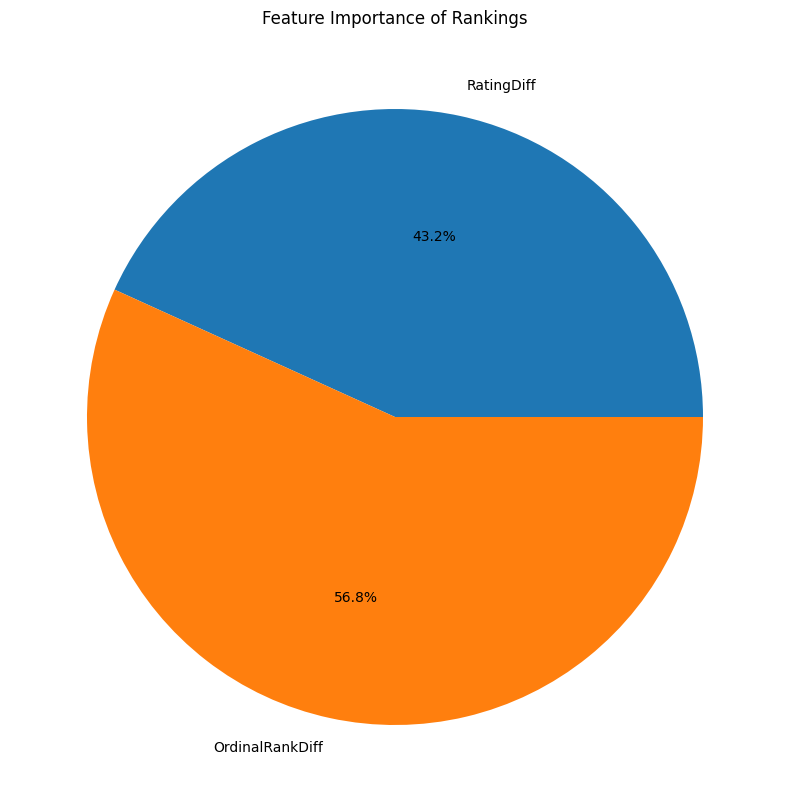

In [52]:
# pie chart of feature importance
plt.figure(figsize=(10, 10))
plt.pie(model.feature_importances_, labels=X.columns, autopct="%1.1f%%")
plt.title("Feature Importance of Rankings")
plt.show()